In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

getting data from kaggle

In [29]:
import os
os.makedirs('../root/.config/kaggle',exist_ok = True)
os.listdir('../root/.config/kaggle')


[]

In [30]:
import os
import json

with open('../root/.config/kaggle/kaggle.json','w') as f:
  # i dont care if public
  key = {"username":"anol666666666","key":"cbee873743914476519082917584e4a0"}
  f.write(
      json.dumps(key)
  )

os.listdir('../root/.config/kaggle')

os.system(r'kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge')
os.listdir()


['.config',
 'challenges-in-representation-learning-facial-expression-recognition-challenge.zip',
 'sample_data']

In [31]:
# now make folder structure. I am pushing a square peg into a round hole here because collab is just so awkward
# and I need it to work with the code I've already written locally

os.makedirs('AdvancedAI/CA2/notebooks',exist_ok = True)
os.makedirs('AdvancedAI/CA2/data/01 Raw',exist_ok = True)
os.makedirs('AdvancedAI/CA2/data/02 Processed',exist_ok = True)

os.rename('challenges-in-representation-learning-facial-expression-recognition-challenge.zip',
          'AdvancedAI/CA2/data/01 Raw/data.zip')

In [32]:
# now unzip
import zipfile
import os

zip_file_path = 'AdvancedAI/CA2/data/01 Raw/data.zip'
destination_folder = 'AdvancedAI/CA2/data/01 Raw/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)


In [33]:
# keeping necessary stuff
directory = 'AdvancedAI/CA2/data/01 Raw'
for f in os.listdir(directory):
  if f == 'train.csv':
    continue
  else:
    os.remove(os.path.join(directory,f))

exploration

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
  os.chdir('AdvancedAI/CA2/notebooks/')
except:
  pass

path = '../data/01 Raw/train.csv'
df = pd.read_csv(path)

In [35]:
df.columns = df.columns.map(lambda x: x.strip().lower())
x = df.pixels.str.split().explode().astype(int).values

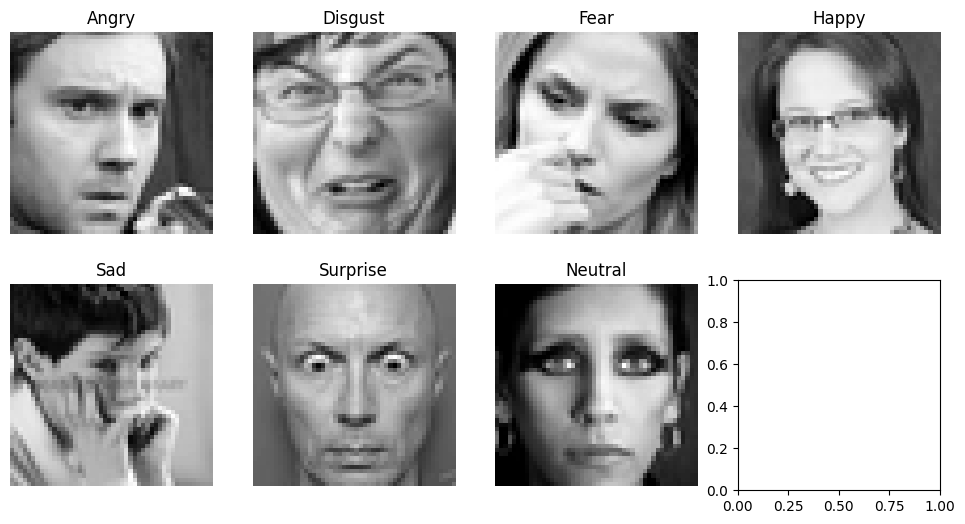

In [36]:
labels = {0 : 'Angry',
              1 : 'Disgust',
              2 : 'Fear',
              3 : 'Happy',
              4 : 'Sad',
              5 : 'Surprise',
              6 : 'Neutral'}
X = x.reshape(-1,48,48)

fig, ax = plt.subplots(2, 4, figsize=(12, 6))
for i in range(7):
    idx = df.loc[df.emotion == i].index[0]
    ax[i//4, i%4].imshow(X[idx], cmap='gray')
    ax[i//4, i%4].set_title(labels[i])
    ax[i//4, i%4].axis('off')

In [37]:
df.emotion.value_counts(normalize=True)

,proportion
emotion,
3,0.251315
6,0.172942
4,0.168240
2,0.142708
0,0.139155
5,0.110453
1,0.015187


In [38]:
(
    df.assign(label=df.emotion.map(labels))
    .groupby('label')
    .agg(count = ('pixels', 'count'))
    .plot(kind='bar', backend='plotly')
    .update_layout(title='Distribution of Emotions in Training Set',showlegend=False)
)


In [39]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df.emotion, random_state=42)
df_train.emotion.value_counts()

,count
emotion,
3,5772
6,3972
4,3864
2,3277
0,3196
5,2537
1,349


In [40]:
df_test.emotion.value_counts()

,count
emotion,
3,1443
6,993
4,966
2,820
0,799
5,634
1,87


In [41]:
from sklearn.utils import resample

def balance_labels(df, label_col):
    max_count = df[label_col].value_counts().max()
    balanced = pd.concat([
        resample(group, replace=True, n_samples=max_count, random_state=42)
        for _, group in df.groupby(label_col)
    ])
    return balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced = balance_labels(df_train, 'emotion')

In [42]:
(
    df_balanced.assign(label=df_balanced.emotion.map(labels))
    .groupby('label')
    .agg(count = ('pixels', 'count'))
    .plot(kind='bar', backend='plotly')
    .update_layout(title='Distribution of Emotions in Training Set',showlegend=False)
)

In [43]:
df_balanced.to_pickle('../data/02 Processed/balancedData.pkl')
df_test.to_pickle('../data/02 Processed/testData.pkl')

Data Processing

In [44]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

try:
  os.chdir('AdvancedAI/CA2/notebooks')
except:
  pass

df = pd.read_pickle("../data/02 Processed/balancedData.pkl")

In [45]:
# Data enrichment
df.drop(columns=["usage"], inplace=True, errors="ignore")
images = df.pixels.str.split().explode().astype(int).values.reshape(-1,48,48)

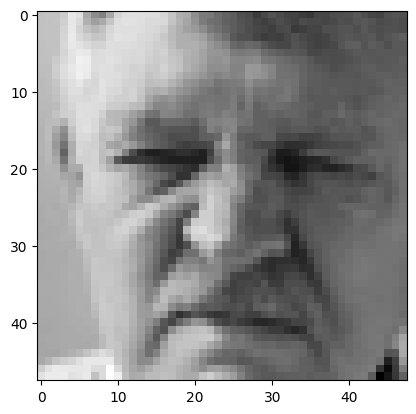

In [46]:
import matplotlib.pyplot as plt
testImage = images[0]
plt.imshow(testImage, cmap="gray")

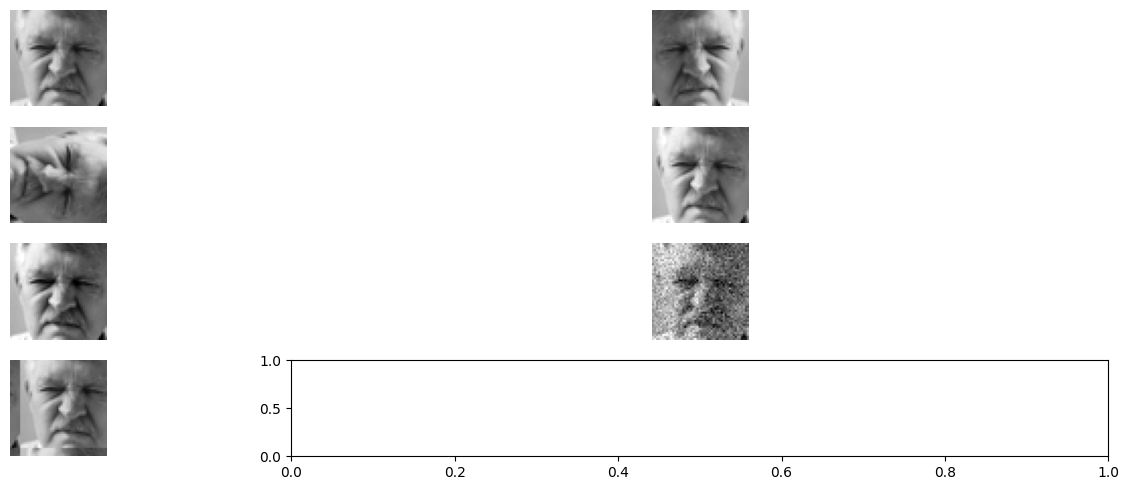

In [47]:
def horizontal_flip(image):
    return np.fliplr(image)
def random_rotation(image):
    angle = np.random.randint(0, 360)
    return np.rot90(image, k=angle//90)
def random_brightness(image):
    factor = np.random.uniform(0.5, 1.5)
    return np.clip(image * factor, 0, 255).astype(np.uint8)
def random_contrast(image):
    factor = np.random.uniform(0.5, 1.5)
    mean = np.mean(image)
    return np.clip((image - mean) * factor + mean, 0, 255).astype(np.uint8)
def random_noise(image):
    noise = np.random.normal(0, 25, image.shape)
    return np.clip(image + noise, 0, 255).astype(np.uint8)
def random_translation(image):
    tx = np.random.randint(-5, 6)
    ty = np.random.randint(-5, 6)
    return np.roll(np.roll(image, tx, axis=1), ty, axis=0)


# plt.imshow(horizontal_flip(testImage), cmap="gray")
# plt.imshow(random_rotation(testImage), cmap="gray")
# plt.imshow(random_brightness(testImage), cmap="gray")
# plt.imshow(random_contrast(testImage), cmap="gray")
# plt.imshow(random_noise(testImage), cmap="gray")
# plt.imshow(random_translation(testImage), cmap="gray")
# plt.imshow(random_zoom(testImage), cmap="gray")

plots = [
    testImage,
    horizontal_flip(testImage),
    random_rotation(testImage),
    random_brightness(testImage),
    random_contrast(testImage),
    random_noise(testImage),
    random_translation(testImage),
]
fig, axes = plt.subplots(4, 2, figsize=(15, 5))

for ax, img in zip(axes.flatten(), plots):
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


def augment_image(image:np.ndarray)-> np.ndarray:
    '''
    one 48x48 image is passed
    returns 10 augmented images

    shape of return will be (10, 48, 48). Goal is then to have overall shape as (len(df),10, 48, 48)
    Then it can be exploded and then flattend down to the string again
    '''
    augmented_images = []

    augmented_images.append(image)
    operations = [
        horizontal_flip,
        random_rotation,
        random_brightness,
        random_contrast,
        random_noise,
        random_translation,
    ]
    for operation in operations:
        augmented_images.append(operation(image))

    # Randomly select 3 images from the augmented images
    selection = np.random.choice(list(range(7)), 3, replace=False)
    for idx in selection:
        # randomly select a function from the list
        fn = np.random.choice(operations)
        augmented_images.append(fn(augmented_images[idx]))
    return np.array(augmented_images)


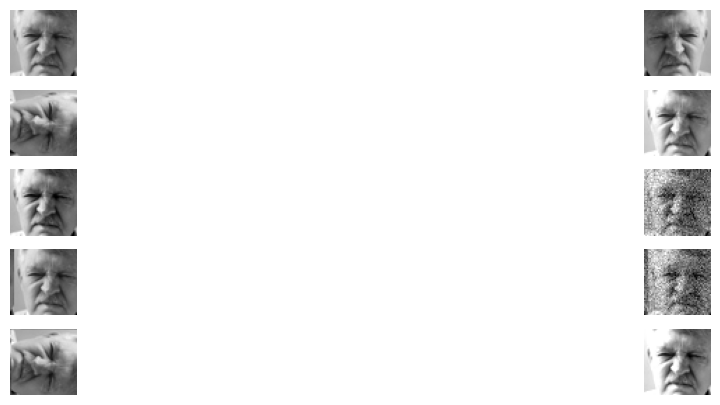

In [48]:
res = augment_image(testImage)


fig, axes = plt.subplots(5, 2, figsize=(15, 5))
for ax, img in zip(axes.flatten(), res):
    ax.imshow(img, cmap="gray")
    ax.axis("off")

In [49]:
testShape = np.array([augment_image(img) for img in images[:3]])
# shape should be (3,10,48,48)
print(testShape.shape)

(3, 10, 48, 48)


In [50]:
testDF = pd.DataFrame(data = dict(emotion = df.emotion[:3].values.tolist(), pixels = df.pixels[:3].values.tolist()))
augmentations = []
for augmentedBatch in testShape:
    res = ''
    for img in augmentedBatch:
        res += ' '.join(map(str, img.flatten())) + '\n'
    res = res.strip()
    augmentations.append(res)

testDF["augmentated_pixels"] = augmentations

(
    testDF
    .assign(augmentated_pixels = lambda s: s.augmentated_pixels.str.split("\n"))
    .explode("augmentated_pixels")

)

,emotion,pixels,augmentated_pixels
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,186 188 187 196 221 214 165 140 130 164 204 21...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,87 88 86 74 77 86 93 87 85 84 77 77 64 69 74 7...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,216 198 165 162 161 163 162 163 164 165 165 16...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,170 172 171 179 202 196 151 128 119 150 187 19...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,203 205 204 216 249 239 175 142 129 174 226 23...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,136 201 180 211 219 236 179 135 140 192 161 20...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,93 85 94 94 185 187 187 206 221 216 209 202 20...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,68 62 68 68 135 136 136 150 161 157 152 147 14...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,52 84 48 58 65 103 96 64 90 58 56 75 52 86 64 ...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,87 87 84 86 93 85 90 89 85 85 75 75 70 66 81 7...


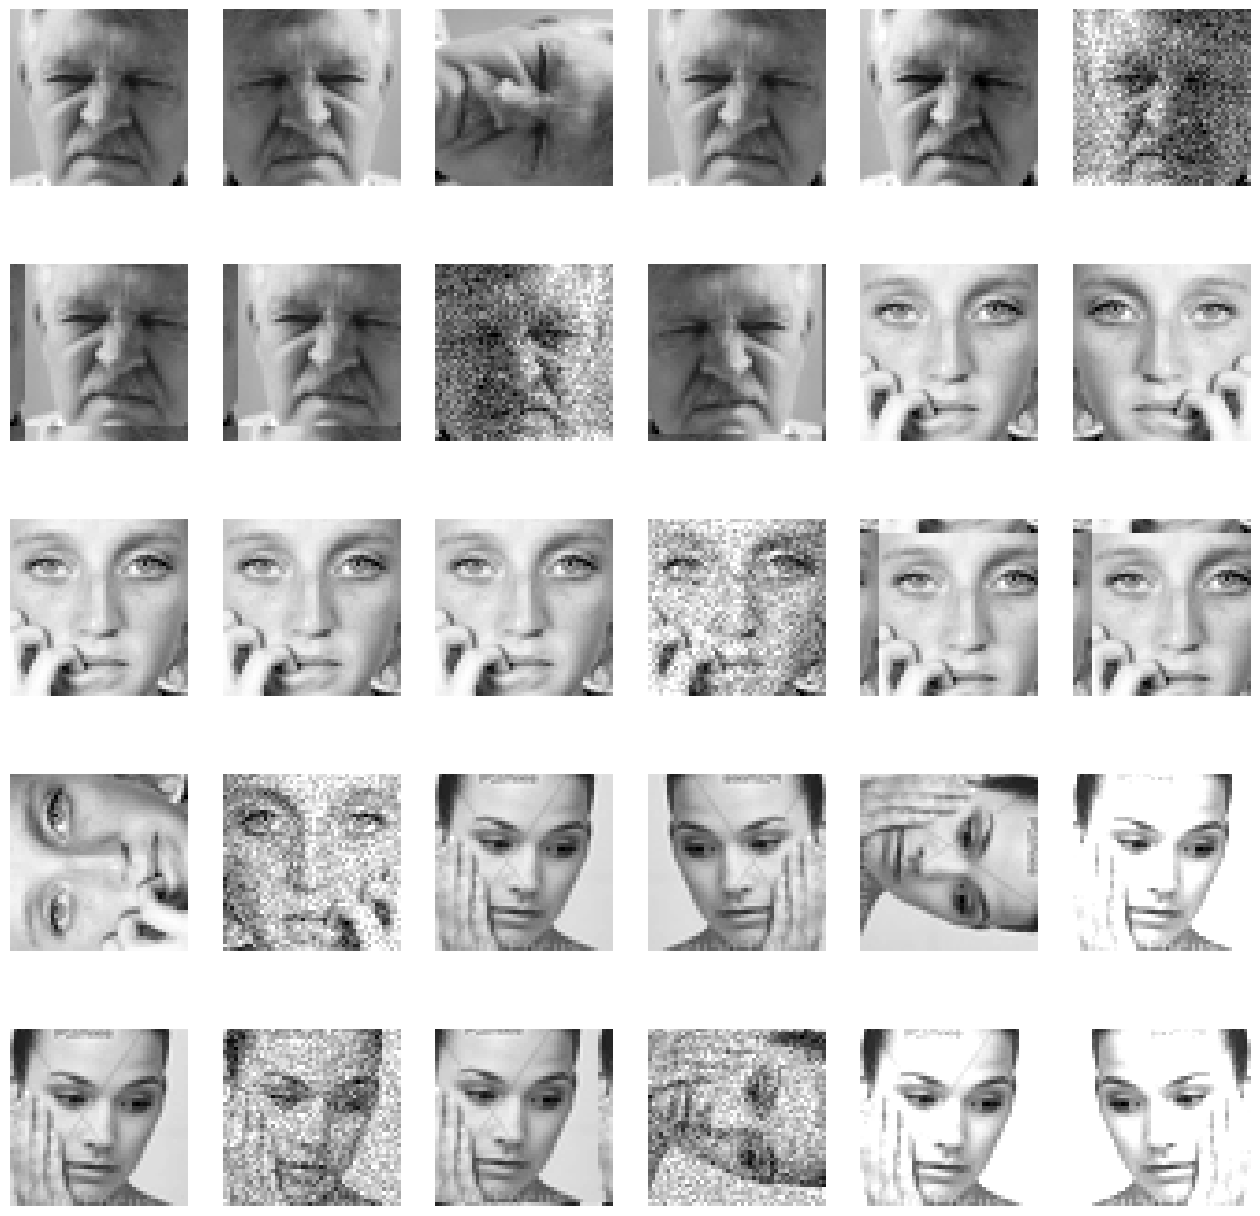

In [51]:

test_ims = (
    testDF
    .assign(augmentated_pixels = lambda s: s.augmentated_pixels.str.split("\n"))
    .explode("augmentated_pixels")
    .augmentated_pixels.str.split().explode().astype(int).values.reshape(-1,48,48)
)

fig, axes = plt.subplots(5, 6, figsize=(16,16))
for ax, img in zip(axes.flatten(), test_ims):
    ax.imshow(img, cmap="gray")
    ax.axis("off")

In [52]:
augmentedBatches = np.array([augment_image(img) for img in images])
print(augmentedBatches.shape) # shape should be (len(df),10,48,48)
augmentedImageStrings = []
for augmentedBatch in augmentedBatches:
    res = ''
    for img in augmentedBatch:
        res += ' '.join(map(str, img.flatten())) + '\n'
    res = res.strip()
    augmentedImageStrings.append(res)
    print("{}/{}".format(len(augmentedImageStrings), len(augmentedBatches)), end = '\r')

print(len(augmentedImageStrings))

df["augmentated_pixels"] = augmentedImageStrings

AugmentedDataFrame = (
    df
    .assign(augmentated_pixels = lambda s: s.augmentated_pixels.str.split("\n"))
    .explode("augmentated_pixels")
    # .reset_index(drop=True)
)

print(AugmentedDataFrame.shape)
print(df.shape)

AugmentedDataFrame = (
    AugmentedDataFrame
    .assign(pixels = AugmentedDataFrame.augmentated_pixels)
    .drop(columns = 'augmentated_pixels')
)

AugmentedDataFrame.to_pickle("../data/02 Processed/train.pkl")

(40404, 10, 48, 48)
40404
(404040, 3)
(40404, 3)


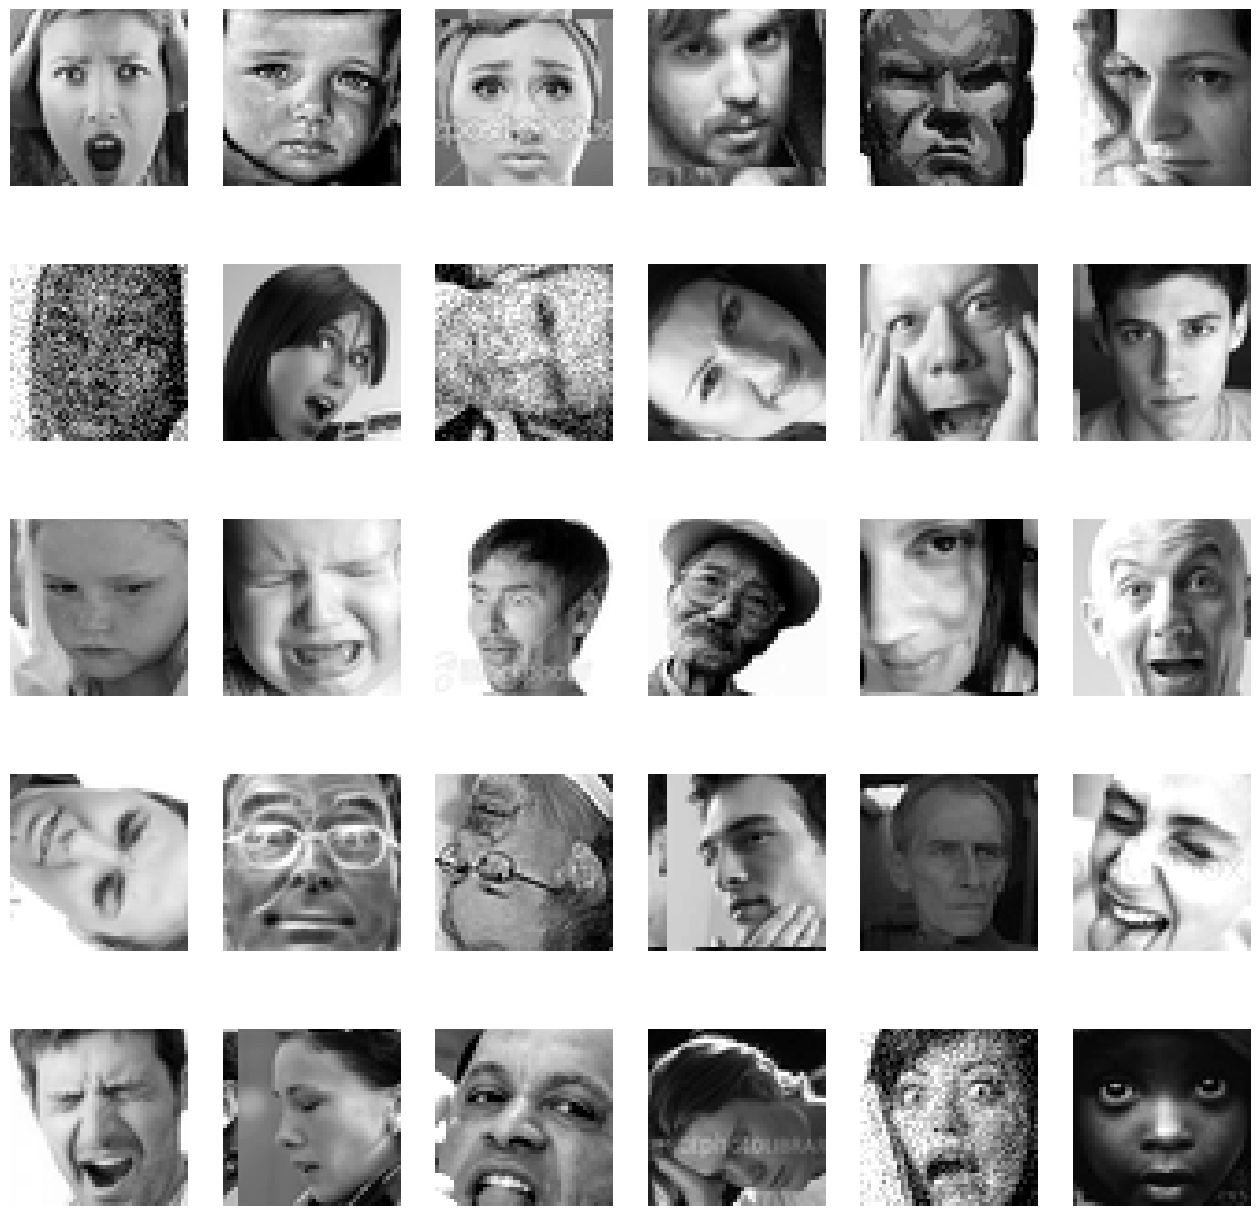

In [53]:
# Randomly select 30 images from AugmentedDataFrame
sample_images = (
    AugmentedDataFrame.reset_index(drop=True)
    .pipe(lambda s: s.loc[np.random.choice(s.index,30)])
    .pixels
    .str.split().explode().astype(int).values.reshape(-1,48,48)
)

fig, axes = plt.subplots(5, 6, figsize=(16,16))
for ax, img in zip(axes.flatten(), sample_images):
    ax.imshow(img, cmap="gray")
    ax.axis("off")

02 pipeline.ipynb


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing._data import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import os

try:
  os.chdir('AdvancedAI/CA2/notebooks')
except:
  pass


In [55]:
TrainingData = pd.read_pickle('../data/02 Processed/train.pkl')
FinalTestData = pd.read_pickle('../data/02 Processed/testData.pkl')

In [56]:
unalteredDataset = pd.read_csv('../data/01 Raw/train.csv')

In [57]:
# remove the predestined test set
unalteredDataset = (
    unalteredDataset.merge(FinalTestData, how = 'outer', indicator = True)
    .query("_merge == 'left_only'")
    .drop(columns = '_merge')
)

(404040, 2)
(321953, 2)


<Axes: xlabel='emotion'>

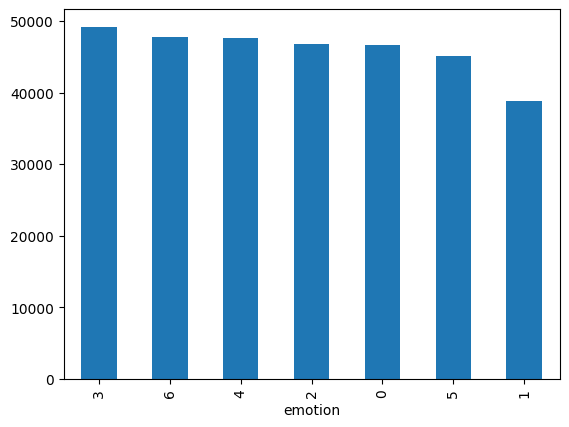

In [58]:
# some got duplicated when increasing the cardinality before augmentation
print(TrainingData.shape)
TrainingData = TrainingData.drop_duplicates().reset_index(drop = True)
print(TrainingData.shape)

TrainingData.emotion.value_counts().plot(kind = 'bar')

In [59]:
# I need to take a random sample of the data with stratification or else I run out of RAM
big,small = train_test_split(TrainingData, test_size=0.6, stratify=TrainingData['emotion'], random_state=42)

<Axes: xlabel='emotion'>

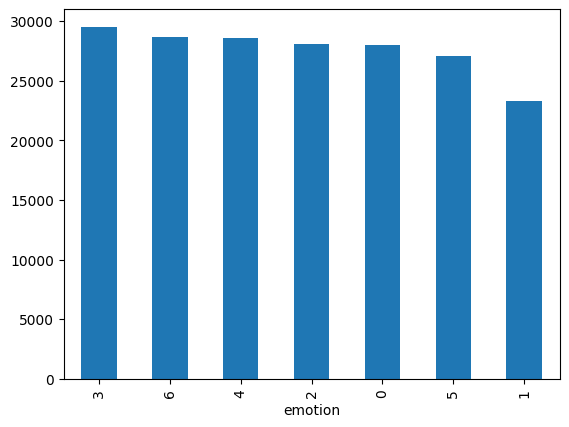

In [60]:
small.emotion.value_counts().plot(kind='bar')

In [61]:
TrainingData = small #Training Data is halved

In [62]:
del big # save memory

In [63]:
# make sure each class has equal representation so accuracy isn't a misleading metric
emotionMin,Min = (
    TrainingData.emotion
    .value_counts()
    .pipe(lambda s:(s.idxmin(),s.min()))
)

idx = TrainingData.index.to_list()
np.random.shuffle(idx)
TrainingData = TrainingData.loc[idx]
TrainingData.reset_index(drop = True)

tmp = pd.DataFrame()
for emotion in TrainingData.emotion.unique():
  tmp = pd.concat([tmp,TrainingData.query(f"emotion == {emotion}").iloc[:Min]])

TrainingData = tmp.copy()
del tmp
TrainingData.emotion.value_counts()

,count
emotion,
5,23311
0,23311
3,23311
6,23311
2,23311
4,23311
1,23311


In [64]:
TrainingData

,emotion,pixels
230316,5,255 255 255 255 166 159 150 143 147 150 150 16...
241809,5,135 137 138 140 140 141 142 112 122 176 192 19...
187902,5,31 29 21 16 16 20 21 39 106 159 164 169 164 17...
137606,5,255 255 250 205 177 220 242 238 238 236 236 23...
219451,5,0 7 45 15 0 8 6 8 24 0 0 8 0 3 7 38 22 24 0 0 ...
...,...,...
149891,1,71 53 32 34 32 38 40 39 39 36 32 24 18 18 21 2...
256374,1,77 32 22 31 18 15 28 22 39 48 65 81 98 114 118...
95723,1,0 0 0 1 0 53 96 114 130 143 151 159 164 169 17...
3357,1,83 61 24 25 33 33 39 44 44 59 52 64 60 60 69 7...


In [65]:

class CustomStandardScaler(OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
    def __init__(self, mu: float, sigma: float):
        self.mu = mu
        self.sigma = sigma
        self.__mean = None
        self.__std = None
        self.__fitted = False

    @property
    def _fitted(self)->bool:
        return self.__fitted

    @_fitted.setter
    def _fitted(self, value: bool):
        if self.__fitted:
            raise AttributeError("The 'fit' method has already been called.")
        if not isinstance(value, bool):
            raise TypeError("The 'fitted' attribute must be a boolean.")
        self.__fitted = value

    @property
    def _mean(self)->np.ndarray:
        '''
        mean of the passed data
        '''
        if self.__mean is None:
            raise AttributeError("The 'fit' method must be called before accessing the mean.")
        return self.__mean

    @property
    def _std(self)->np.ndarray:
        '''
        std of the passed data
        '''
        if self.__std is None:
            raise AttributeError("The 'fit' method must be called before accessing the std.")
        return self.__std

    def fit(self, X: np.ndarray)-> 'CustomStandardScaler':
        self._fitted = True
        self.__mean = X.mean(axis=0)
        self.__std = X.std(axis=0)
        return self

    def transform(self, X: np.ndarray)-> np.ndarray:
        newX = X - self._mean
        newX = (newX / self._std) * self.sigma
        return newX+self.mu

    def fit_transform(self, X:np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X:np.ndarray) -> np.ndarray:
        newX = X - self.mu
        newX = (newX / self._std) * self.sigma
        return newX + self._mean

class CustomMinMaxScaler(OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
    def __init__(self):
        self.__min = None
        self.__max = None
        self.__fitted = False

    @property
    def _fitted(self)->bool:
        return self.__fitted

    @_fitted.setter
    def _fitted(self, value: bool):
        if self.__fitted:
            raise AttributeError("The 'fit' method has already been called.")
        if not isinstance(value, bool):
            raise TypeError("The 'fitted' attribute must be a boolean.")
        self.__fitted = value

    @property
    def _min(self)->np.ndarray:
        '''
        min of the passed data
        '''
        if self.__min is None:
            raise AttributeError("The 'fit' method must be called before accessing the min.")
        return self.__min

    @property
    def _max(self)->np.ndarray:
        '''
        max of the passed data
        '''
        if self.__max is None:
            raise AttributeError("The 'fit' method must be called before accessing the max.")
        return self.__max

    def fit(self, X: np.ndarray)-> 'CustomStandardScaler':
        self._fitted = True
        self.__min = X.min(axis=0)
        self.__max = X.max(axis=0)
        return self

    def transform(self, X: np.ndarray)-> np.ndarray:
        return (X - self._min)/(self._max - self._min)

    def fit_transform(self, X:np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X:np.ndarray) -> np.ndarray:
        return X * (self._max - self._min) + self._min

class Data(Dataset):
    _identityFunc = lambda x: x
    def __init__(self,data:pd.DataFrame, transform:transforms = None, scaler:BaseEstimator = None):
        # making them private so can't be altered
        if not scaler:
            scaler = CustomStandardScaler(0, 0.25)

        self.__transform = transform if transform else Data._identityFunc
        self.__Y = data['emotion'].astype(int).values.tolist()
        self.__X = data.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48)
        self.__len = data.shape[0]
        try:
            self.__X = scaler.fit_transform(self.__X).astype(np.float32)
        except AttributeError:
            print("Already fit")
            self.__X = scaler.transform(self.__X).astype(np.float32)

    def __len__(self)->int:
        return self.__len

    def __getitem__(self, index)->tuple[np.ndarray,np.ndarray]:
        img:np.ndarray = self.__X[index]
        emotion:int = self.__Y[index]
        label = np.zeros((7,), dtype=np.float32)
        label[emotion] = 1
        return self.__transform(img), label

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.residual = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 12 * 12, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 100),
            nn.Sigmoid(),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        residual = x
        x = self.residual(x)
        x += residual
        x = nn.ReLU()(x)

        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x



In [66]:

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # get accuracy
        predicted = outputs.argmax(axis=1)
        target = labels.argmax(axis=1)
        correct = (predicted == target).sum().item()
        accuracy = correct / labels.size(0)
    return running_loss / len(dataloader), accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          predicted = outputs.argmax(axis=1)
          total += labels.size(0)
          correct += (predicted == labels.argmax(axis = 1)).sum().item()

    return running_loss / len(dataloader), correct / total

In [67]:
class CustomLoss(nn.Module):
    '''
    nn.CrossEntropyLosss is annoying me the way it expects labels
    it also does the softmax part itself.

    this class expects two R^n vectors or two arrays of R^n vectors
    it then penalises the difference using negative log liklihood
    '''
    def __init__(self):
        super(CustomLoss, self).__init__()
    def forward(self, probabilites:torch.Tensor, target:torch.Tensor)->torch.Tensor:
        '''
        probabilites: R^n
        target: R^n
        '''
        return -torch.sum(target * torch.log(probabilites + 1e-10), dim=1).mean()

In [68]:
import traceback as tb

def doTrainingLoop(num_epochs:int,
                   _model,
                   _train_loader,
                   _test_loader,
                   _criterion,
                   _optimizer,
                   _device):
  trainingResults = list()

  try:
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(_model, _train_loader, _criterion, _optimizer, _device)
        test_loss, accuracy = evaluate(_model, _test_loader, _criterion, _device)

        results = dict(zip(['epoch','train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'],
                          [epoch+1,train_loss, train_accuracy, test_loss, accuracy]))
        trainingResults.append(results)
        print(f"Epoch [{epoch+1}/{num_epochs}], \
        Train Loss: {train_loss:.4f}, \
        Train Accuracy: {train_accuracy:.4f}, \
        Test Loss: {test_loss:.4f}, \
        Test Accuracy: {accuracy:.4f}")
  except KeyboardInterrupt:
    pass
  except Exception as e:
    print('an exception occured :{}\ntb:\n{}'.format(e,
                                                     ''.join(tb.format_exception(type(e), e, e.__traceback__)))
    )
    pass


  return (
      pd.DataFrame(trainingResults)
      .melt(id_vars = 'epoch')
      .assign(colIndicator = lambda s: s.variable.apply(lambda x: 'train' if 'train' in x else 'test'))
      .assign(rowIndicator = lambda s: s.variable.apply(lambda x: 'loss' if 'loss' in x else 'accuracy'))
      .plot(x = 'epoch',
            facet_row = 'rowIndicator',
            y = 'value',
            color = 'colIndicator',
            backend = 'plotly')
      .update_yaxes(matches = None)
  )

In [69]:
torch.cuda.is_available()
torch.cuda.empty_cache()

transformers = transforms.Compose([
    transforms.ToTensor(),
])

print('fitting scaler')
scaler = CustomStandardScaler(0, 0.25) #<- Pretty good - 37% accuracy on test set, 95% on training set
scaler.fit(unalteredDataset.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48)) #scale using augmented data

print('making dataset')
test_data = Data(FinalTestData, transform=transformers, scaler=scaler)

print('making dataloader')
test_loader = DataLoader(test_data, batch_size=len(FinalTestData), shuffle = True)



fitting scaler
making dataset
Already fit
making dataloader


In [70]:
print('making model')
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)
criterion = CustomLoss()

making model


In [71]:
# train firstly on enriched/balanced dataset

print('making dataset')
enriched_train_data = Data(TrainingData, transform=transformers, scaler=scaler)

print('making dataloader')
enriched_train_loader = DataLoader(enriched_train_data, shuffle = True, batch_size=15_000)#int(len(TrainingData)/2))
enrichedOptimizer = optim.Adam(model.parameters(), lr=.01) #<- smaller learning rate


making dataset
Already fit
making dataloader


In [72]:
doTrainingLoop(20,
               model,
               enriched_train_loader,
               test_loader,
               criterion,
               enrichedOptimizer,
               device)

Epoch [1/20],         Train Loss: 1.9383,         Train Accuracy: 0.2510,         Test Loss: 1.8493,         Test Accuracy: 0.2525
Epoch [2/20],         Train Loss: 1.8154,         Train Accuracy: 0.3080,         Test Loss: 1.8057,         Test Accuracy: 0.2875
Epoch [3/20],         Train Loss: 1.6941,         Train Accuracy: 0.3700,         Test Loss: 1.5750,         Test Accuracy: 0.3924
Epoch [4/20],         Train Loss: 1.5846,         Train Accuracy: 0.4074,         Test Loss: 1.5152,         Test Accuracy: 0.4249
Epoch [5/20],         Train Loss: 1.4896,         Train Accuracy: 0.4377,         Test Loss: 1.5090,         Test Accuracy: 0.4324
Epoch [6/20],         Train Loss: 1.4037,         Train Accuracy: 0.4634,         Test Loss: 1.3610,         Test Accuracy: 0.4753
Epoch [7/20],         Train Loss: 1.3362,         Train Accuracy: 0.5011,         Test Loss: 1.2872,         Test Accuracy: 0.4990
Epoch [8/20],         Train Loss: 1.2739,         Train Accuracy: 0.5236,         T

In [73]:
# Then train on the unaltered dataset
unaltered_train_data = Data(unalteredDataset, transform=transformers, scaler=scaler)
unaltered_train_loader = DataLoader(unaltered_train_data, shuffle = True, batch_size=15000)
unaltered_optimizer = optim.Adam(model.parameters(), lr=.001)


Already fit


In [74]:
doTrainingLoop(20,
               model,
               unaltered_train_loader,
               test_loader,
               criterion,
               unaltered_optimizer,
               device)

Epoch [1/20],         Train Loss: 0.9253,         Train Accuracy: 0.6945,         Test Loss: 1.1511,         Test Accuracy: 0.5918
Epoch [2/20],         Train Loss: 0.8743,         Train Accuracy: 0.7088,         Test Loss: 1.1450,         Test Accuracy: 0.5918
Epoch [3/20],         Train Loss: 0.8513,         Train Accuracy: 0.7143,         Test Loss: 1.1398,         Test Accuracy: 0.5963
Epoch [4/20],         Train Loss: 0.8378,         Train Accuracy: 0.7080,         Test Loss: 1.1387,         Test Accuracy: 0.5984
Epoch [5/20],         Train Loss: 0.8083,         Train Accuracy: 0.7289,         Test Loss: 1.1404,         Test Accuracy: 0.5980
Epoch [6/20],         Train Loss: 0.7923,         Train Accuracy: 0.7350,         Test Loss: 1.1422,         Test Accuracy: 0.5947
Epoch [7/20],         Train Loss: 0.7922,         Train Accuracy: 0.7371,         Test Loss: 1.1388,         Test Accuracy: 0.5970
Epoch [8/20],         Train Loss: 0.7782,         Train Accuracy: 0.7387,         T

In [75]:
doTrainingLoop(20,
               model,
               unaltered_train_loader,
               test_loader,
               criterion,
               unaltered_optimizer,
               device)

Epoch [1/20],         Train Loss: 0.7098,         Train Accuracy: 0.7502,         Test Loss: 1.1177,         Test Accuracy: 0.6057
Epoch [2/20],         Train Loss: 0.6932,         Train Accuracy: 0.7610,         Test Loss: 1.1199,         Test Accuracy: 0.6062
Epoch [3/20],         Train Loss: 0.6845,         Train Accuracy: 0.7646,         Test Loss: 1.1208,         Test Accuracy: 0.6059
Epoch [4/20],         Train Loss: 0.6802,         Train Accuracy: 0.7666,         Test Loss: 1.1209,         Test Accuracy: 0.6068
Epoch [5/20],         Train Loss: 0.6781,         Train Accuracy: 0.7639,         Test Loss: 1.1215,         Test Accuracy: 0.6061
Epoch [6/20],         Train Loss: 0.6813,         Train Accuracy: 0.7705,         Test Loss: 1.1224,         Test Accuracy: 0.6071
Epoch [7/20],         Train Loss: 0.6700,         Train Accuracy: 0.7696,         Test Loss: 1.1231,         Test Accuracy: 0.6085
Epoch [8/20],         Train Loss: 0.6642,         Train Accuracy: 0.7757,         T

Pred Emotion: Sad
True Emotion: Neutral
Certainty: 64.00%


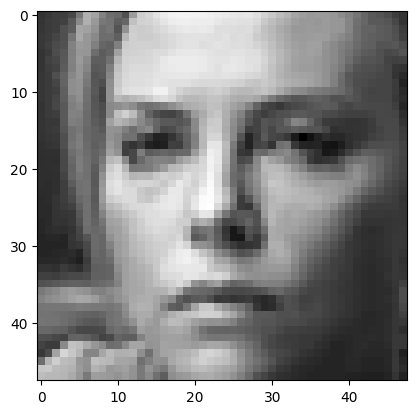

In [93]:
# Predictions
import matplotlib.pyplot as plt

idx = np.random.randint(0,len(test_data))

images = (
    FinalTestData
    .iloc[idx:idx+1]
    .pixels
    .str.split()
    .explode().astype(np.uint8)
    .values.reshape(-1,48,48))

plt.imshow(images[0],'grey')

inputs = scaler.transform(images)
probabilities = model(torch.tensor(inputs,dtype=torch.float).reshape(-1,1,48,48).to(device))

predEmotion = probabilities.argmax()
label = FinalTestData.iloc[idx,0]
certainty = probabilities[0,predEmotion]

labelsMapping = {0 : 'Angry',
              1 : 'Disgust',
              2 : 'Fear',
              3 : 'Happy',
              4 : 'Sad',
              5 : 'Surprise',
              6 : 'Neutral'}

predEmotion = labelsMapping[int(predEmotion)]
trueEmotion = labelsMapping[label]
certainty = '{:,.2f}%'.format(100*certainty)

print('Pred Emotion: {}'.format(predEmotion))
print('True Emotion: {}'.format(trueEmotion))
print('Certainty: {}'.format(certainty))


predicted emotion:Happy


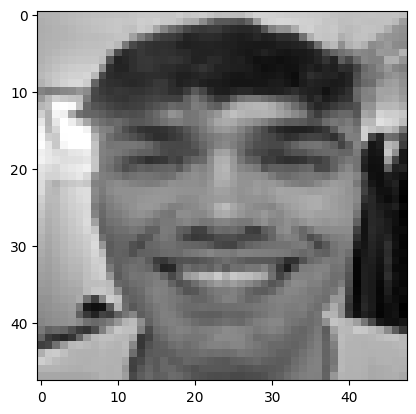

In [114]:
MySelfie = [
	[177, 174, 173, 174, 175, 176, 177, 181, 185, 178, 132, 155, 182, 208, 229, 243, 250, 253, 239, 242, 227, 222, 219, 218, 207, 201, 195, 188, 185, 180, 175, 171, 167, 164, 160, 157, 153, 149, 144, 140, 135, 122, 101, 65, 175, 206, 179, 168],
	[178, 177, 175, 176, 178, 180, 183, 186, 192, 190, 124, 182, 191, 180, 178, 184, 206, 229, 231, 232, 220, 211, 189, 187, 185, 181, 178, 174, 172, 169, 167, 165, 162, 160, 158, 155, 153, 149, 147, 143, 141, 100, 61, 72, 200, 197, 180, 168],
	[180, 180, 178, 178, 180, 183, 188, 193, 199, 201, 129, 206, 252, 245, 230, 214, 201, 200, 220, 227, 214, 211, 175, 183, 186, 184, 183, 181, 179, 176, 174, 172, 169, 167, 164, 161, 159, 155, 151, 147, 144, 106, 50, 114, 203, 187, 179, 168],
	[183, 183, 180, 180, 183, 187, 192, 199, 205, 209, 136, 199, 255, 240, 255, 255, 254, 247, 219, 221, 226, 220, 193, 201, 200, 197, 194, 191, 188, 185, 183, 181, 178, 174, 171, 167, 164, 159, 153, 148, 146, 101, 40, 157, 191, 181, 177, 167],
	[185, 186, 183, 182, 185, 190, 196, 203, 209, 215, 139, 193, 251, 169, 238, 255, 255, 255, 229, 223, 231, 224, 199, 210, 208, 206, 203, 199, 197, 193, 191, 188, 184, 181, 177, 171, 167, 162, 158, 153, 150, 82, 55, 185, 180, 179, 175, 167],
	[187, 189, 187, 185, 188, 192, 197, 205, 209, 216, 151, 189, 197, 114, 207, 255, 255, 255, 231, 224, 235, 231, 204, 219, 216, 211, 209, 207, 203, 198, 195, 191, 186, 182, 178, 174, 169, 171, 123, 96, 139, 61, 102, 189, 177, 177, 174, 167],
	[189, 191, 189, 187, 190, 193, 197, 205, 213, 204, 140, 124, 104, 103, 167, 244, 255, 255, 237, 229, 241, 216, 198, 221, 221, 216, 217, 219, 214, 205, 202, 199, 194, 192, 190, 189, 186, 114, 26, 58, 114, 53, 157, 184, 177, 176, 177, 168],
	[191, 194, 192, 187, 190, 194, 198, 209, 184, 101, 74, 72, 86, 102, 125, 154, 182, 195, 193, 198, 197, 146, 131, 139, 135, 125, 132, 162, 196, 213, 218, 213, 207, 203, 199, 189, 198, 66, 17, 36, 106, 79, 185, 180, 177, 178, 178, 171],
	[192, 196, 194, 189, 191, 194, 189, 145, 75, 57, 60, 68, 80, 95, 112, 131, 138, 130, 130, 128, 124, 128, 127, 124, 119, 110, 107, 101, 99, 113, 150, 186, 203, 208, 206, 191, 199, 136, 20, 69, 112, 128, 191, 186, 181, 180, 178, 178],
	[193, 197, 197, 191, 196, 161, 85, 49, 47, 51, 55, 60, 71, 86, 103, 126, 111, 118, 125, 120, 115, 124, 136, 139, 131, 126, 122, 114, 105, 98, 92, 94, 107, 123, 151, 186, 190, 204, 89, 62, 125, 172, 191, 182, 178, 178, 176, 176],
	[194, 199, 199, 195, 184, 78, 36, 38, 43, 48, 58, 56, 65, 79, 108, 103, 97, 120, 121, 103, 98, 119, 141, 145, 140, 134, 126, 118, 112, 104, 101, 100, 98, 96, 92, 105, 144, 192, 181, 99, 151, 198, 185, 180, 178, 177, 178, 177],
	[194, 197, 193, 195, 121, 45, 41, 39, 44, 44, 56, 54, 62, 82, 98, 81, 92, 120, 114, 86, 80, 108, 137, 145, 145, 141, 134, 126, 113, 105, 101, 97, 101, 108, 106, 100, 94, 106, 110, 118, 180, 191, 183, 186, 182, 166, 152, 159],
	[197, 198, 191, 162, 76, 50, 49, 49, 45, 42, 53, 60, 65, 79, 88, 68, 83, 120, 107, 71, 88, 114, 131, 145, 145, 146, 143, 132, 120, 106, 83, 83, 106, 115, 118, 110, 102, 98, 89, 135, 187, 190, 169, 137, 110, 67, 65, 75],
	[200, 205, 203, 127, 60, 59, 57, 56, 45, 45, 53, 63, 68, 82, 88, 55, 71, 116, 98, 62, 99, 118, 128, 146, 150, 153, 147, 131, 116, 86, 76, 98, 111, 110, 116, 115, 109, 104, 101, 95, 143, 129, 57, 56, 65, 76, 87, 94],
	[201, 203, 197, 102, 53, 52, 59, 57, 48, 51, 58, 67, 77, 94, 94, 51, 57, 105, 97, 49, 93, 117, 125, 148, 152, 154, 142, 123, 99, 88, 103, 100, 93, 104, 121, 120, 125, 119, 112, 107, 100, 78, 70, 84, 90, 96, 102, 107],
	[201, 207, 168, 74, 51, 50, 55, 52, 48, 59, 62, 71, 85, 107, 102, 51, 48, 88, 89, 55, 98, 114, 127, 150, 153, 151, 131, 115, 98, 112, 107, 102, 62, 75, 125, 128, 133, 130, 123, 119, 117, 109, 98, 94, 94, 90, 91, 95],
	[199, 200, 134, 65, 50, 52, 53, 46, 47, 59, 59, 68, 92, 125, 114, 53, 49, 76, 77, 57, 100, 110, 135, 151, 152, 141, 121, 123, 124, 122, 113, 108, 57, 37, 102, 127, 129, 127, 128, 129, 127, 117, 109, 99, 94, 104, 104, 99],
	[199, 199, 110, 63, 48, 50, 56, 46, 41, 46, 48, 68, 106, 148, 124, 61, 59, 74, 72, 72, 103, 115, 145, 150, 150, 129, 118, 123, 123, 116, 113, 110, 74, 41, 75, 100, 121, 123, 122, 127, 130, 126, 122, 110, 97, 92, 105, 109],
	[205, 190, 95, 55, 37, 45, 53, 41, 35, 35, 47, 66, 100, 140, 126, 72, 65, 73, 76, 65, 89, 132, 143, 148, 141, 130, 142, 129, 98, 92, 106, 108, 83, 88, 98, 82, 103, 117, 112, 117, 126, 132, 124, 116, 106, 94, 95, 107],
	[198, 174, 74, 39, 34, 44, 46, 40, 34, 39, 62, 99, 102, 118, 118, 87, 79, 75, 77, 89, 115, 139, 144, 147, 140, 136, 142, 135, 92, 69, 103, 118, 85, 111, 152, 91, 86, 110, 108, 105, 120, 129, 119, 110, 106, 104, 89, 96],
	[201, 171, 63, 41, 36, 37, 36, 47, 39, 43, 90, 119, 126, 120, 120, 103, 95, 87, 78, 101, 137, 144, 144, 147, 142, 139, 137, 128, 66, 58, 101, 122, 84, 100, 164, 110, 88, 102, 108, 99, 110, 123, 119, 116, 109, 101, 84, 86],
	[204, 141, 58, 46, 37, 36, 37, 54, 42, 35, 72, 98, 120, 131, 129, 121, 112, 103, 96, 106, 133, 139, 141, 147, 150, 147, 137, 120, 68, 61, 99, 127, 88, 106, 185, 129, 104, 102, 111, 96, 104, 127, 120, 125, 114, 98, 89, 84],
	[197, 110, 63, 46, 39, 36, 45, 46, 39, 30, 42, 77, 102, 139, 149, 137, 121, 117, 128, 141, 145, 148, 153, 154, 152, 155, 148, 123, 95, 65, 89, 135, 94, 98, 182, 143, 117, 110, 109, 95, 103, 129, 128, 131, 111, 93, 89, 79],
	[189, 91, 61, 44, 36, 39, 44, 36, 36, 30, 32, 57, 95, 152, 167, 151, 128, 132, 160, 173, 176, 175, 171, 162, 156, 177, 169, 132, 109, 77, 74, 127, 103, 114, 202, 156, 124, 120, 110, 96, 108, 133, 140, 132, 113, 91, 89, 78],
	[191, 90, 51, 37, 35, 36, 36, 36, 29, 27, 31, 59, 124, 177, 171, 155, 134, 138, 164, 176, 182, 178, 170, 161, 157, 188, 172, 134, 107, 79, 70, 126, 111, 93, 177, 149, 125, 130, 112, 103, 113, 140, 139, 130, 111, 88, 88, 79],
	[188, 87, 45, 34, 33, 31, 32, 33, 25, 23, 37, 90, 162, 191, 170, 148, 131, 127, 143, 153, 155, 161, 159, 153, 154, 168, 162, 127, 110, 80, 69, 122, 104, 113, 200, 159, 130, 129, 112, 102, 109, 138, 139, 135, 113, 96, 87, 76],
	[187, 84, 43, 31, 29, 28, 34, 32, 24, 23, 43, 115, 175, 182, 156, 133, 120, 113, 109, 119, 136, 147, 148, 147, 145, 155, 151, 122, 101, 72, 87, 131, 97, 111, 192, 148, 121, 116, 115, 101, 107, 134, 137, 135, 121, 98, 84, 76],
	[199, 101, 43, 35, 28, 25, 26, 30, 27, 23, 43, 121, 179, 177, 150, 114, 101, 94, 84, 99, 130, 146, 148, 151, 147, 145, 142, 122, 65, 73, 100, 130, 91, 120, 189, 138, 103, 104, 116, 106, 117, 130, 125, 126, 118, 102, 86, 78],
	[212, 155, 48, 41, 27, 29, 19, 23, 24, 24, 35, 121, 182, 177, 141, 93, 87, 81, 74, 92, 122, 145, 155, 157, 148, 139, 144, 135, 63, 74, 106, 128, 90, 119, 179, 124, 94, 108, 120, 114, 127, 123, 111, 120, 113, 106, 89, 79],
	[211, 206, 86, 34, 27, 36, 21, 17, 22, 24, 34, 111, 183, 180, 130, 77, 77, 78, 71, 63, 86, 141, 151, 151, 146, 138, 153, 145, 94, 83, 112, 127, 89, 133, 166, 105, 93, 119, 122, 119, 131, 127, 114, 113, 111, 98, 88, 84],
	[210, 212, 131, 37, 28, 30, 20, 19, 23, 29, 32, 102, 173, 176, 116, 56, 73, 74, 61, 64, 97, 125, 153, 158, 152, 134, 143, 131, 105, 102, 114, 126, 88, 107, 113, 87, 102, 129, 126, 127, 136, 133, 117, 107, 105, 96, 90, 92],
	[208, 215, 149, 48, 33, 25, 17, 22, 26, 30, 34, 90, 156, 165, 104, 43, 60, 74, 61, 53, 97, 110, 146, 166, 162, 149, 138, 135, 138, 124, 116, 124, 78, 60, 70, 97, 124, 133, 130, 129, 136, 127, 114, 107, 99, 93, 93, 99],
	[206, 214, 146, 48, 33, 23, 20, 19, 20, 24, 40, 85, 137, 154, 93, 36, 49, 85, 77, 48, 94, 108, 134, 165, 165, 157, 150, 145, 144, 132, 116, 121, 48, 30, 94, 128, 136, 132, 126, 122, 122, 117, 107, 103, 97, 95, 102, 110],
	[205, 212, 172, 53, 36, 27, 22, 20, 15, 17, 48, 78, 111, 139, 94, 35, 53, 100, 85, 51, 94, 115, 128, 165, 166, 163, 156, 139, 123, 128, 123, 113, 51, 78, 132, 140, 135, 129, 125, 121, 117, 106, 103, 100, 103, 109, 113, 120],
	[205, 208, 206, 114, 40, 27, 26, 29, 33, 30, 38, 53, 89, 125, 91, 35, 65, 113, 86, 55, 102, 120, 124, 163, 170, 168, 164, 149, 105, 107, 125, 107, 83, 125, 132, 138, 130, 127, 128, 122, 112, 102, 104, 106, 114, 118, 123, 127],
	[203, 207, 209, 174, 57, 31, 29, 36, 49, 38, 35, 36, 56, 84, 80, 38, 70, 116, 96, 67, 107, 123, 127, 159, 172, 172, 166, 157, 121, 80, 109, 113, 107, 127, 131, 129, 123, 124, 118, 110, 109, 110, 114, 118, 124, 128, 130, 130],
	[202, 204, 199, 198, 111, 42, 38, 29, 43, 35, 32, 48, 40, 62, 83, 46, 69, 118, 103, 64, 74, 119, 138, 160, 173, 173, 161, 154, 138, 93, 72, 101, 115, 132, 136, 129, 123, 116, 111, 118, 116, 122, 125, 128, 129, 131, 131, 129],
	[200, 197, 197, 195, 173, 77, 54, 37, 37, 32, 20, 30, 46, 82, 108, 57, 63, 108, 106, 75, 76, 114, 148, 163, 166, 166, 160, 150, 139, 117, 90, 97, 124, 132, 127, 117, 114, 111, 134, 182, 145, 94, 99, 102, 101, 102, 98, 100],
	[194, 197, 200, 197, 185, 101, 37, 33, 39, 28, 31, 37, 60, 95, 120, 90, 50, 96, 108, 98, 99, 129, 157, 162, 159, 160, 160, 154, 141, 127, 117, 115, 121, 116, 112, 111, 120, 151, 172, 180, 195, 162, 143, 129, 121, 119, 126, 152],
	[192, 190, 190, 175, 144, 115, 95, 49, 30, 30, 37, 50, 70, 105, 114, 127, 79, 69, 102, 111, 124, 144, 154, 157, 154, 154, 156, 150, 141, 130, 126, 124, 124, 118, 113, 125, 149, 153, 143, 144, 188, 185, 188, 186, 183, 183, 184, 180],
	[191, 191, 186, 184, 176, 124, 74, 47, 39, 39, 50, 55, 74, 105, 124, 133, 128, 93, 103, 123, 137, 146, 150, 148, 150, 150, 152, 148, 141, 134, 126, 113, 98, 92, 85, 80, 72, 61, 52, 57, 180, 184, 181, 180, 180, 178, 177, 177],
	[192, 194, 190, 193, 186, 139, 108, 69, 79, 85, 106, 103, 83, 87, 106, 120, 127, 134, 124, 116, 116, 134, 122, 137, 138, 130, 118, 98, 68, 50, 33, 17, 8, 7, 7, 5, 7, 10, 13, 17, 160, 201, 179, 180, 179, 178, 178, 177],
	[193, 192, 195, 194, 176, 135, 136, 106, 113, 107, 130, 133, 146, 167, 184, 208, 207, 111, 51, 38, 32, 73, 63, 68, 52, 37, 26, 20, 20, 21, 23, 27, 30, 33, 35, 33, 33, 38, 42, 35, 119, 199, 180, 177, 178, 177, 176, 175],
	[194, 191, 194, 188, 141, 131, 130, 119, 118, 111, 135, 131, 148, 160, 183, 195, 70, 23, 22, 19, 17, 19, 25, 37, 43, 41, 42, 43, 44, 41, 38, 36, 33, 30, 29, 28, 28, 28, 29, 25, 74, 187, 181, 179, 177, 173, 170, 170],
	[193, 192, 191, 159, 146, 155, 131, 136, 124, 143, 165, 165, 182, 211, 224, 184, 39, 33, 26, 20, 18, 16, 16, 19, 23, 30, 35, 39, 36, 32, 29, 25, 21, 18, 15, 11, 9, 10, 8, 7, 26, 173, 187, 180, 178, 177, 171, 171],
	[193, 193, 174, 150, 155, 152, 174, 153, 143, 157, 163, 169, 182, 204, 216, 192, 111, 184, 197, 159, 98, 32, 27, 19, 14, 26, 22, 29, 30, 39, 50, 47, 50, 42, 49, 36, 32, 24, 16, 16, 18, 139, 192, 179, 178, 178, 173, 173],
	[194, 185, 151, 147, 140, 151, 175, 135, 150, 161, 166, 172, 184, 205, 209, 176, 107, 171, 144, 70, 34, 26, 36, 29, 23, 34, 18, 18, 14, 17, 20, 14, 18, 12, 20, 17, 11, 15, 19, 21, 17, 93, 194, 182, 178, 176, 177, 174],
	[190, 158, 146, 143, 138, 179, 150, 128, 141, 146, 151, 157, 172, 198, 188, 120, 74, 64, 25, 25, 38, 18, 7, 6, 3, 11, 4, 7, 13, 8, 7, 11, 8, 11, 12, 10, 15, 9, 2, 4, 24, 56, 184, 185, 181, 177, 175, 169],
]
MySelfie = np.array(MySelfie).T
scaledImage = scaler.transform(MySelfie)
tensorImage = torch.tensor(scaledImage,dtype=torch.float).reshape(-1,1,48,48)

probabilities = model(tensorImage.to(device))
plt.imshow(MySelfie,cmap = 'grey')

prediction = probabilities.argmax()
predEmotion = labelsMapping[int(prediction)]
print('predicted emotion:' + predEmotion)
